# Assignment 8

### Exercise 8

In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

(a) Split the data set into a training set and a test set.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge

In [3]:
carseat = pd.read_csv("https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Carseats.csv")
carseat.head()

Unnamed: 0  Sales  CompPrice  Income  Advertising  Population  Price  \
0           1   9.50        138      73           11         276    120   
1           2  11.22        111      48           16         260     83   
2           3  10.06        113      35           10         269     80   
3           4   7.40        117     100            4         466     97   
4           5   4.15        141      64            3         340    128   

  ShelveLoc  Age  Education Urban   US  
0       Bad   42         17   Yes  Yes  
1      Good   65         10   Yes  Yes  
2    Medium   59         12   Yes  Yes  
3    Medium   55         14   Yes  Yes  
4       Bad   38         13   Yes   No

In [4]:
carseat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   400 non-null    int64  
 1   Sales        400 non-null    float64
 2   CompPrice    400 non-null    int64  
 3   Income       400 non-null    int64  
 4   Advertising  400 non-null    int64  
 5   Population   400 non-null    int64  
 6   Price        400 non-null    int64  
 7   ShelveLoc    400 non-null    object 
 8   Age          400 non-null    int64  
 9   Education    400 non-null    int64  
 10  Urban        400 non-null    object 
 11  US           400 non-null    object 
dtypes: float64(1), int64(8), object(3)
memory usage: 37.6+ KB


In [5]:
X = carseat.drop(['Sales', 'Unnamed: 0', 'ShelveLoc', 'Urban', 'US'], axis =1)
y = carseat['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 100)

(b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [6]:
tree = DecisionTreeRegressor(max_depth = 3, random_state = 100) 
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

6.850490213554101

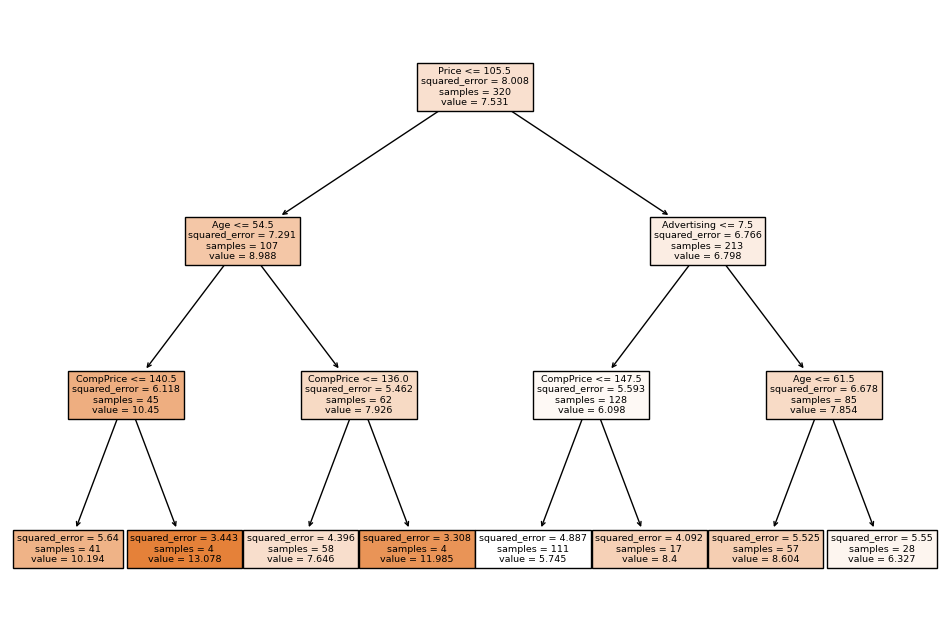

In [7]:
plt.subplots(figsize = (12,8))
plot_tree(tree, feature_names = X.columns, filled = True)
plt.show()

(c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [8]:
param_grid = {'max_depth': range(1, 11), 'min_samples_leaf': range(1, 11)}

tree = DecisionTreeRegressor(random_state = 42)
grid_search = GridSearchCV(tree, param_grid, cv = 10, scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Best parameters: {'max_depth': 4, 'min_samples_leaf': 9}
Best score: 6.040340079100168


In [9]:
tree = DecisionTreeRegressor(max_depth = grid_search.best_params_['max_depth'], 
                             min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
                            random_state = 100)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

7.053894508807295

Prunning the tree in this case does not improve the MSE

(d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important.

In [10]:
bag_reg = BaggingRegressor(base_estimator = tree, n_estimators = 100, bootstrap = True, random_state = 100)
bag_reg.fit(X_train, y_train)
y_pred = bag_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

4.8935367029617485

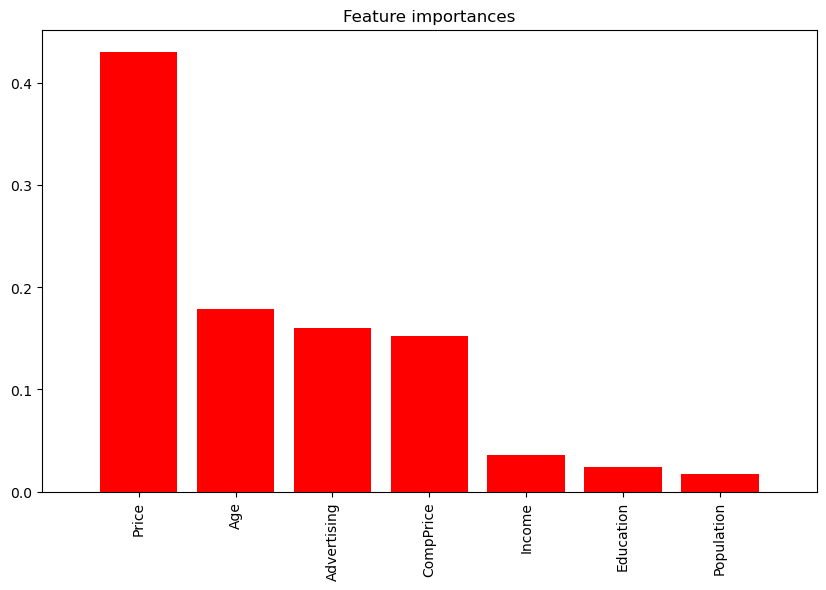

In [11]:
importances = np.mean([tree.feature_importances_ for tree in bag_reg.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [12]:
rf = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', random_state = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

4.927678801375

In [13]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Variable importances:")
print(importances)

Variable importances:
Price          0.274664
Age            0.159402
CompPrice      0.141128
Advertising    0.127370
Income         0.119822
Population     0.106191
Education      0.071422
dtype: float64


### Exercise 10

We now use boosting to predict Salary in the Hitters data set (baseball data).

(a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [14]:
hitters = pd.read_csv("https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Hitters.csv")
hitters.head()

Unnamed: 0  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  \
0     -Andy Allanson    293    66      1    30   29     14      1     293   
1        -Alan Ashby    315    81      7    24   38     39     14    3449   
2       -Alvin Davis    479   130     18    66   72     76      3    1624   
3      -Andre Dawson    496   141     20    65   78     37     11    5628   
4  -Andres Galarraga    321    87     10    39   42     30      2     396   

   CHits  ...  CRuns  CRBI  CWalks  League Division PutOuts  Assists  Errors  \
0     66  ...     30    29      14       A        E     446       33      20   
1    835  ...    321   414     375       N        W     632       43      10   
2    457  ...    224   266     263       A        W     880       82      14   
3   1575  ...    828   838     354       N        E     200       11       3   
4    101  ...     48    46      33       N        E     805       40       4   

   Salary  NewLeague  
0     NaN          A  
1   475.0          N  
2   480.0          A  
3   500.0          N  
4    91.5          N  

[5 rows x 21 columns]

In [15]:
hitters = hitters.set_index('Unnamed: 0')
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

In [16]:
hitters = hitters.dropna()
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [17]:
hitters['Salary'] = np.log(hitters['Salary'])

(b) Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [18]:
X = hitters.drop('Salary', axis = 1)
y = hitters['Salary']
X_train = X.iloc[:200, :]
X_test = X.iloc[200:, :]
y_train = y.iloc[:200]
y_test = y.iloc[200:]

(c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

In [23]:
ct = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(sparse=False, drop='first'), ['League', 'Division', 'NewLeague'])
], remainder='passthrough')

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

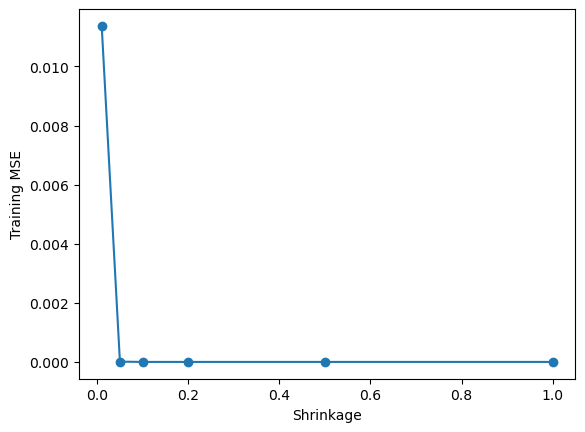

In [24]:
shrinkage_vals = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
train_mses = []
test_mses = []

for shrinkage in shrinkage_vals:
    gb = GradientBoostingRegressor(n_estimators = 1000, learning_rate = shrinkage, random_state = 0)
    gb.fit(X_train, y_train)
    train_mse = mean_squared_error(y_train, gb.predict(X_train))
    train_mses.append(train_mse)
    test_mse = mean_squared_error(y_test, gb.predict(X_test) )
    test_mses.append(test_mse)
    
plt.plot(shrinkage_vals, train_mses, marker='o')
plt.xlabel('Shrinkage')
plt.ylabel('Training MSE')
plt.show()

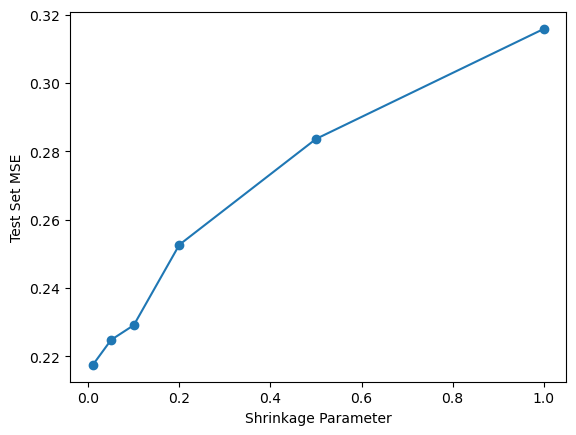

In [25]:
plt.plot(shrinkage_vals, test_mses, 'o-')
plt.xlabel('Shrinkage Parameter')
plt.ylabel('Test Set MSE')
plt.show()

In [26]:
min(test_mses)

0.2174847006149666

(e) Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

In [27]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)
lm_mse = mean_squared_error(y_test, lm_pred)

In [28]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)

In [29]:
print('Test MSE for Multiple Linear Regression:', lm_mse)
print('Test MSE for Ridge Regression:', ridge_mse)
print('Test MSE for Boosting:', min(test_mses))

Test MSE for Multiple Linear Regression: 0.49179593754549805
Test MSE for Ridge Regression: 0.49277626094574684
Test MSE for Boosting: 0.2174847006149666


(f) Which variables appear to be the most important predictors in the boosted model?

In [37]:
importances = gb.feature_importances_
features = list(X.columns)
feature_importances = list(zip(features, importances))
print("Feature importances:")
for feature in feature_importances:
    print(feature[0], ": ", feature[1])

Feature importances:
AtBat :  8.098737926188815e-05
Hits :  2.3298262018591703e-06
HmRun :  0.002367192988918567
Runs :  0.0001777236511331322
RBI :  0.08863316194034251
Walks :  0.004537400785011832
Years :  0.00296403064406307
CAtBat :  0.02371399366117587
CHits :  0.07645651606564183
CHmRun :  0.015080455406616542
CRuns :  0.6140725708702801
CRBI :  0.01779072543759262
CWalks :  0.011341541143010118
League :  0.0620198810303522
Division :  0.024371058949149038
PutOuts :  0.006721812443256982
Assists :  0.019466696140851586
Errors :  0.01194457167508395
NewLeague :  0.018257349962056395


(g) Now apply bagging to the training set. What is the test set MSE for this approach?

In [39]:
rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt')
bag = BaggingRegressor(base_estimator = rf, n_estimators= 50, random_state = 100)
bag.fit(X_train, y_train)

y_pred = bag.predict(X_test)
mse_bag = mean_squared_error(y_test, y_pred)
print("Test set MSE of bagging:", mse_bag)

Test set MSE of bagging: 0.22469506421470534
